# Continuity Analysis

In [1]:
# data loading
from aif_gen.dataset.continual_alignment_dataset import ContinualAlignmentDataset

lipschitz_data = ContinualAlignmentDataset.from_json(
    'data/4omini_generation/merged_tech_physics.json'
)
piecewise_data = ContinualAlignmentDataset.from_json(
    'data/4omini_generation/merged_politics_generate.json'
)

# only get the prompts shuffled and only 10K prompts
data_lip = lipschitz_data.datasets[0].samples
data_piecewise = piecewise_data.datasets[0].samples

prompts_lip = []
for sample in data_lip:
    prompts_lip.append(sample.prompt)

# randomly shuffle the prompts and keep only 10K
import random

random.shuffle(prompts_lip)
prompts_lip = prompts_lip[:10000]

prompts_piecewise = []
for sample in data_piecewise:
    prompts_piecewise.append(sample.prompt)
# randomly shuffle the prompts and keep only 10K
random.shuffle(prompts_piecewise)
prompts_piecewise = prompts_piecewise[:10000]
print(prompts_piecewise[:10])
print(prompts_lip[:10])

/home/mila/s/shahrad.mohammadzadeh/projects/AIF-Gen/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


["As the political landscape continues to shift, the looming prospect of impeachment hearings has captured the attention of the American public. In recent weeks, officials from both sides of the aisle have been weighing in on the implications of such an unprecedented move. \n\nIn the latest developments, congressional leaders have announced plans to convene hearings that will address multiple allegations against the president, ranging from misuse of power to obstruction of justice. These hearings mark a pivotal moment in American politics, as they are not just a mechanism for accountability but also a reflection of the current partisan divide. s, who largely support the push for impeachment, argue that it is crucial to uphold the integrity of the office. Meanwhile, s have positioned themselves against what they perceive as a political witch hunt, claiming these efforts aim to weaken the presidency rather than serve justice.\n\nThe hearings are expected to spotlight testimony from key w

||T12|| = 0.86,  ||T23|| = 0.83


Interp T12: 100%|██████████| 11/11 [13:07<00:00, 71.56s/it]


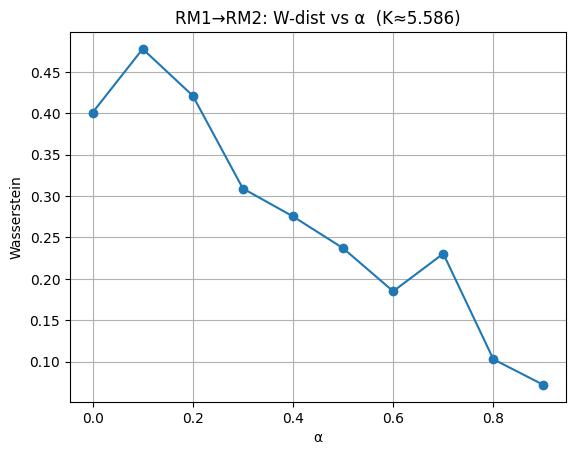

Interp T23: 100%|██████████| 11/11 [13:05<00:00, 71.39s/it]


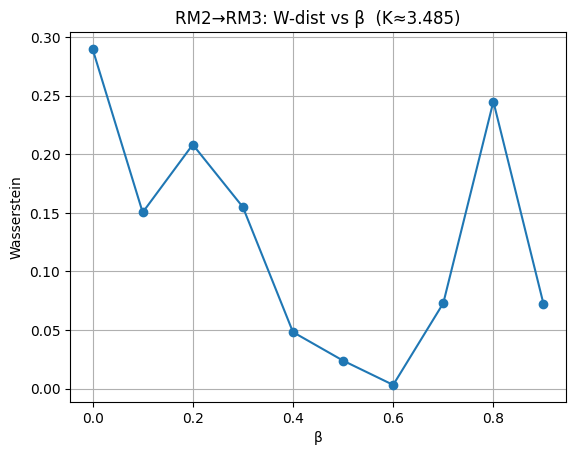

Empirical Lipschitz constants: K12=5.5859, K23=3.4846


In [2]:
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer


# -----------------------------------------------------------------------------
# Utilities for state‐dict arithmetic & norms
# -----------------------------------------------------------------------------
def subtract_state_dicts(sd_a, sd_b):
    return {k: sd_a[k] - sd_b[k] for k in sd_a}


def add_scaled(sd_base, sd_delta, alpha):
    return {k: sd_base[k] + alpha * sd_delta[k] for k in sd_base}


def state_dict_norm(sd):
    total = torch.stack([v.flatten().dot(v.flatten()) for v in sd.values()]).sum()
    return torch.sqrt(total).item()


# -----------------------------------------------------------------------------
# Load your 3 reward models & tokenizer
# -----------------------------------------------------------------------------
paths = [
    'LifelongAlignment/aifgen-lipschitz-0-reward-model',
    'LifelongAlignment/aifgen-lipschitz-1-reward-model',
    'LifelongAlignment/aifgen-lipschitz-2-reward-model',
]

models = [
    AutoModelForSequenceClassification.from_pretrained(
        p,
        torch_dtype=torch.bfloat16,
        cache_dir='//network/scratch/s/shahrad.mohammadzadeh/.cache',
    ).cuda()
    for p in paths
]
tokenizer = AutoTokenizer.from_pretrained(paths[0])

# -----------------------------------------------------------------------------
# Compute task vectors & their norms
# -----------------------------------------------------------------------------
sd1, sd2, sd3 = [m.state_dict() for m in models]
T12 = subtract_state_dicts(sd2, sd1)
T23 = subtract_state_dicts(sd3, sd2)
norm12 = state_dict_norm(T12)
norm23 = state_dict_norm(T23)
print(f'||T12|| = {norm12:.2f},  ||T23|| = {norm23:.2f}')

# -----------------------------------------------------------------------------
# Load your prompts
# -----------------------------------------------------------------------------
prompts = prompts_lip

# In experiments.ipynb, add a new cell before your interpolation

from torch.utils.data import DataLoader, Dataset


class PromptDataset(Dataset):
    def __init__(self, prompts):
        self.prompts = prompts

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, i):
        return self.prompts[i]


def compute_rewards(model, prompts, batch_size=64, num_workers=4):
    """Compute reward scores in batches."""
    model.eval()
    ds = PromptDataset(prompts)
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=lambda batch: tokenizer(
            batch,
            return_tensors='pt',
            padding=True,
            truncation=True,
        ),
    )
    rewards = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.cuda(non_blocking=True) for k, v in batch.items()}
            logits = model(**batch).logits
            # if binary head, pick class 1; else regression head
            if logits.shape[-1] > 1:
                vals = logits[:, 1]
            else:
                vals = logits[:, 0]
            rewards.extend(vals.cpu().tolist())
    return rewards


# -----------------------------------------------------------------------------
# Interpolate along T12 (RM1 → RM2)
# -----------------------------------------------------------------------------
alphas = np.linspace(0, 1, 11)
all_rewards_12 = []
for α in tqdm(alphas, desc='Interp T12'):
    sd_interp = add_scaled(sd1, T12, α)
    m = copy.deepcopy(models[0])
    m.load_state_dict(sd_interp)
    all_rewards_12.append(compute_rewards(m, prompts, batch_size=1024))

# Wasserstein distances & Lipschitz estimate
dists12 = [
    wasserstein_distance(all_rewards_12[i], all_rewards_12[i + 1])
    for i in range(len(alphas) - 1)
]
rates12 = [d / ((alphas[i + 1] - alphas[i]) * norm12) for i, d in enumerate(dists12)]
K12 = max(rates12)

plt.figure()
plt.plot(alphas[:-1], dists12, marker='o')
plt.title(f'RM1→RM2: W-dist vs α  (K≈{K12:.3f})')
plt.xlabel('α')
plt.ylabel('Wasserstein')
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# Interpolate along T23 (RM2 → RM3)
# -----------------------------------------------------------------------------
betas = np.linspace(0, 1, 11)
all_rewards_23 = []
for β in tqdm(betas, desc='Interp T23'):
    sd_interp = add_scaled(sd2, T23, β)
    m = copy.deepcopy(models[1])
    m.load_state_dict(sd_interp)
    all_rewards_23.append(compute_rewards(m, prompts, batch_size=1024))

dists23 = [
    wasserstein_distance(all_rewards_23[i], all_rewards_23[i + 1])
    for i in range(len(betas) - 1)
]
rates23 = [d / ((betas[i + 1] - betas[i]) * norm23) for i, d in enumerate(dists23)]
K23 = max(rates23)

plt.figure()
plt.plot(betas[:-1], dists23, marker='o')
plt.title(f'RM2→RM3: W-dist vs β  (K≈{K23:.3f})')
plt.xlabel('β')
plt.ylabel('Wasserstein')
plt.grid(True)
plt.show()

print(f'Empirical Lipschitz constants: K12={K12:.4f}, K23={K23:.4f}')

||T12|| = 0.83,  ||T23|| = 0.88


Interp T12:   0%|          | 0/11 [00:00<?, ?it/s]/home/mila/s/shahrad.mohammadzadeh/projects/AIF-Gen/.venv/lib/python3.10/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 3, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Interp T12: 100%|██████████| 11/11 [08:19<00:00, 45.39s/it]


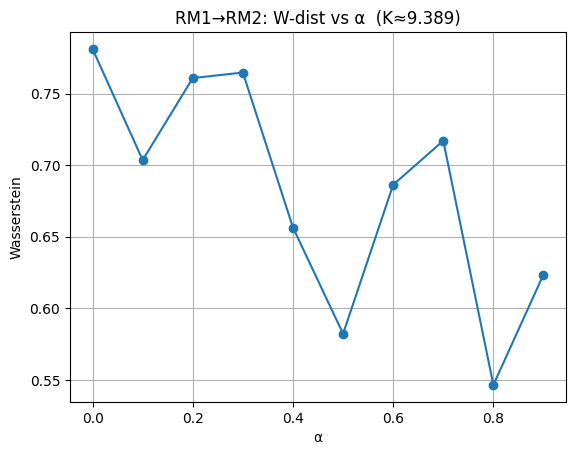

Interp T23: 100%|██████████| 11/11 [08:16<00:00, 45.12s/it]


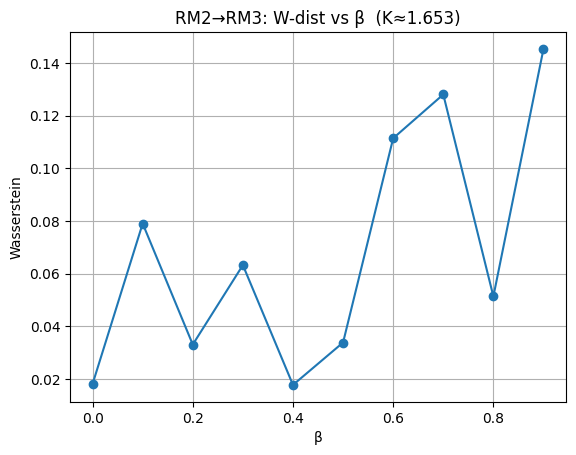

Empirical Lipschitz constants: K12=9.3892, K23=1.6530


In [ ]:
import copy
import torch
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import wasserstein
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer


# -----------------------------------------------------------------------------
# Utilities for state‐dict arithmetic & norms
# -----------------------------------------------------------------------------
def subtract_state_dicts(sd_a, sd_b):
    return {k: sd_a[k] - sd_b[k] for k in sd_a}


def add_scaled(sd_base, sd_delta, alpha):
    return {k: sd_base[k] + alpha * sd_delta[k] for k in sd_base}


def state_dict_norm(sd):
    total = torch.stack([v.flatten().dot(v.flatten()) for v in sd.values()]).sum()
    return torch.sqrt(total).item()


# -----------------------------------------------------------------------------
# Load your 3 reward models & tokenizer
# -----------------------------------------------------------------------------
paths = [
    'LifelongAlignment/aifgen-piecewise-preference-shift-0-reward-model',
    'LifelongAlignment/aifgen-piecewise-preference-shift-1-reward-model',
    'LifelongAlignment/aifgen-piecewise-preference-shift-2-reward-model',
]

models = [
    AutoModelForSequenceClassification.from_pretrained(
        p,
        torch_dtype=torch.bfloat16,
        cache_dir='//network/scratch/s/shahrad.mohammadzadeh/.cache',
    ).cuda()
    for p in paths
]
tokenizer = AutoTokenizer.from_pretrained(paths[0])

# -----------------------------------------------------------------------------
# Compute task vectors & their norms
# -----------------------------------------------------------------------------
sd1, sd2, sd3 = [m.state_dict() for m in models]
T12 = subtract_state_dicts(sd2, sd1)
T23 = subtract_state_dicts(sd3, sd2)
norm12 = state_dict_norm(T12)
norm23 = state_dict_norm(T23)
print(f'||T12|| = {norm12:.2f},  ||T23|| = {norm23:.2f}')

# -----------------------------------------------------------------------------
# Load your prompts
# -----------------------------------------------------------------------------
prompts = prompts_piecewise

# In experiments.ipynb, add a new cell before your interpolation

from torch.utils.data import DataLoader, Dataset


class PromptDataset(Dataset):
    def __init__(self, prompts):
        self.prompts = prompts

    def __len__(self):
        return len(self.prompts)

    def __getitem__(self, i):
        return self.prompts[i]


def compute_rewards(model, prompts, batch_size=64, num_workers=4):
    """Compute reward scores in batches."""
    model.eval()
    ds = PromptDataset(prompts)
    loader = DataLoader(
        ds,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=lambda batch: tokenizer(
            batch,
            return_tensors='pt',
            padding=True,
            truncation=True,
        ),
    )
    rewards = []
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.cuda(non_blocking=True) for k, v in batch.items()}
            logits = model(**batch).logits
            # if binary head, pick class 1; else regression head
            if logits.shape[-1] > 1:
                vals = logits[:, 1]
            else:
                vals = logits[:, 0]
            rewards.extend(vals.cpu().tolist())
    return rewards


# -----------------------------------------------------------------------------
# Interpolate along T12 (RM1 → RM2)
# -----------------------------------------------------------------------------
alphas = np.linspace(0, 1, 11)
all_rewards_12 = []
for α in tqdm(alphas, desc='Interp T12'):
    sd_interp = add_scaled(sd1, T12, α)
    m = copy.deepcopy(models[0])
    m.load_state_dict(sd_interp)
    all_rewards_12.append(compute_rewards(m, prompts, batch_size=1024))

# Wasserstein distances & Lipschitz estimate
dists12 = [
    wasserstein_distance(all_rewards_12[i], all_rewards_12[i + 1])
    for i in range(len(alphas) - 1)
]
rates12 = [d / ((alphas[i + 1] - alphas[i]) * norm12) for i, d in enumerate(dists12)]
K12 = max(rates12)

plt.figure()
plt.plot(alphas[:-1], dists12, marker='o')
plt.title(f'RM1→RM2: W-dist vs α  (K≈{K12:.3f})')
plt.xlabel('α')
plt.ylabel('Wasserstein')
plt.grid(True)
plt.show()

# -----------------------------------------------------------------------------
# Interpolate along T23 (RM2 → RM3)
# -----------------------------------------------------------------------------
betas = np.linspace(0, 1, 11)
all_rewards_23 = []
for β in tqdm(betas, desc='Interp T23'):
    sd_interp = add_scaled(sd2, T23, β)
    m = copy.deepcopy(models[1])
    m.load_state_dict(sd_interp)
    all_rewards_23.append(compute_rewards(m, prompts, batch_size=1024))

dists23 = [
    wasserstein_distance(all_rewards_23[i], all_rewards_23[i + 1])
    for i in range(len(betas) - 1)
]
rates23 = [d / ((betas[i + 1] - betas[i]) * norm23) for i, d in enumerate(dists23)]
K23 = max(rates23)

plt.figure()
plt.plot(betas[:-1], dists23, marker='o')
plt.title(f'RM2→RM3: W-dist vs β  (K≈{K23:.3f})')
plt.xlabel('β')
plt.ylabel('Wasserstein')
plt.grid(True)
plt.show()

print(f'Empirical Lipschitz constants: K12={K12:.4f}, K23={K23:.4f}')